In [133]:
from collections import deque
import tqdm
import bench_utils
from shapely.geometry import shape
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
import random
import numpy as np
from shapely.geometry import shape
from intersection.plotting import xs, ys

fpd = FpdExtended()

df, unary_idxs = bench_utils.read_dataset()
unary_idxs = list(set(unary_idxs))

MEMORY_SLOTS = 5
USE_FLAT_LIST = True

# Export delta properties
x, y = [], []
bins = []
for idx in tqdm.tqdm(unary_idxs, disable=True): # List of single idxs
    _, bin = fpd.compress(shape(df.iloc[idx]))
    chunks, _ = fpd.get_chunks(bin, include_ring_start=False)
    bins.append(bin)
    X_shape = []
    y_shape = []
    for c in chunks:
        prevs = [(c[0])]
        for coord in c[1:]:
            if len(prevs) > MEMORY_SLOTS:
                prevs.pop()

            X_small = [prevs[i] if len(prevs) > i else [0, 0] for i in range(MEMORY_SLOTS)]
            y_small = coord
            prevs.insert(0, coord)
            if USE_FLAT_LIST:
                X_shape.append([xs(X_small), ys(X_small)])
            else:
                X_shape.append(X_small)
            y_shape.append(y_small)

    x.append((idx, X_shape))
    y.append(y_shape)

In [134]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor
x = np.array(x, dtype=object)
y = np.array(y, dtype=object)

In [135]:
print(x.shape)
#X = X.reshape((-1, X.shape[1] * X.shape[2]))
#print(X.shape)
print(y.shape)

(10259, 2)
(10259,)


In [136]:
print(x)
print(y)

[[1
  list([[[13.1854398, 0, 0, 0, 0], [55.706723, 0, 0, 0, 0]], [[13.185471, 13.1854398, 0, 0, 0], [55.7068707, 55.706723, 0, 0, 0]], [[13.1854744, 13.185471, 13.1854398, 0, 0], [55.7068789, 55.7068707, 55.706723, 0, 0]], [[13.1854789, 13.1854744, 13.185471, 13.1854398, 0], [55.7068869, 55.7068789, 55.7068707, 55.706723, 0]], [[13.1854845, 13.1854789, 13.1854744, 13.185471, 13.1854398], [55.7068948, 55.7068869, 55.7068789, 55.7068707, 55.706723]], [[13.1854916, 13.1854845, 13.1854789, 13.1854744, 13.185471], [55.7069015, 55.7068948, 55.7068869, 55.7068789, 55.7068707]], [[13.1855013, 13.1854916, 13.1854845, 13.1854789, 13.1854744], [55.7069071, 55.7069015, 55.7068948, 55.7068869, 55.7068789]], [[13.1855122, 13.1855013, 13.1854916, 13.1854845, 13.1854789], [55.7069116, 55.7069071, 55.7069015, 55.7068948, 55.7068869]], [[13.1855242, 13.1855122, 13.1855013, 13.1854916, 13.1854845], [55.7069151, 55.7069116, 55.7069071, 55.7069015, 55.7068948]], [[13.1855366, 13.1855242, 13.1855122, 13.185

In [137]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(x, y, random_state=50,test_size=0.3)
X_validation, X_test, y_validation, y_test = model_selection.train_test_split(X_validation, y_validation, random_state=50,test_size=0.3)

def scramble_and_unpack(X, y):
    '''
    Returns the ID of the shape and scrambles the chunks within the data set.
    Note that the steps above are done in order to avoid overlap (using the same shape)
    between the different sets.
    '''
    X_shapes = [x[0] for x in X]
        
    X_stripped = [x[1] for x in X]
    X_stripped = [item for sublist in X_stripped for item in sublist]
    
    X_long_shapes = []
    for i in range(len(X_shapes)):
        X_long_shapes += [X_shapes[i] for _ in range(len(X[i][1]))]
    
    y_flat = [item for sublist in y for item in sublist]
    X_shapes, X_stripped, y_flat = shuffle(X_long_shapes, X_stripped, y_flat, random_state=0)

    X_stripped = np.array(X_stripped)
    y_flat = np.array(y_flat)
    if USE_FLAT_LIST:
        X_stripped = np.reshape(X_stripped, (-1, X_stripped.shape[1] * X_stripped.shape[2]))

    return np.array(X_shapes), X_stripped, y_flat

train_geometries, X_train, y_train = scramble_and_unpack(X_train, y_train)
validation_geometries, X_validation, y_validation = scramble_and_unpack(X_validation, y_validation)
test_geometries, X_test, y_test = scramble_and_unpack(X_test, y_test)

print('train data shape:',np.shape(X_train))
print('validation data shape:',np.shape(X_validation))
print('train labels shape:',np.shape(y_train))
print('validation labels shape:',np.shape(y_validation))
print('test labels shape:',np.shape(X_test))
print('test labels shape:',np.shape(y_test))

train data shape: (45560, 10)
validation data shape: (13123, 10)
train labels shape: (45560, 2)
validation labels shape: (13123, 2)
test labels shape: (5858, 10)
test labels shape: (5858, 2)


In [138]:
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

#train_data = (train_data-mean) / std
#validation_data = (validation_data-mean) / std

#print(train_data)
print(mean, std)

[13.19739005 10.85768374  8.82155485  6.96212636  5.75185146 55.70403398
 45.82863669 37.23460533 29.3864038  24.27814419] [1.66030211e-02 5.04019070e+00 6.21296217e+00 6.58858416e+00
 6.54400031e+00 8.69680474e-03 2.12737885e+01 2.62240243e+01
 2.78096786e+01 2.76217115e+01]


In [139]:
X_train[0]

array([13.1903213,  0.       ,  0.       ,  0.       ,  0.       ,
       55.7187569,  0.       ,  0.       ,  0.       ,  0.       ])

In [140]:
y_train[0]

array([13.1902883, 55.7185565])

In [141]:
X_validation[0]

array([13.2224964, 13.2223376, 13.2223703,  0.       ,  0.       ,
       55.7005577, 55.7005314, 55.7004687,  0.       ,  0.       ])

In [142]:
import gc
gc.collect() # used to clear gpu memory 

0

In [143]:
if False: 
    neural_net = MLPRegressor(max_iter=2000).fit(X_train, y_train)
    ## Result
    y_hat = neural_net.predict(X_validation)

    PRINT_VALIDATION = False

    pred_better_cnt = 0
    for i in range(len(y_hat)):
        prev = X_validation[i][0:2]
        predicted_is_better =  np.linalg.norm(y[i] - y_hat[i]) < np.linalg.norm(y[i] - prev)
        pred_better_cnt = pred_better_cnt + 1 if predicted_is_better else pred_better_cnt
        if PRINT_VALIDATION:
            print(prev)
            print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
            print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
            print('Better:', 'YES' if predicted_is_better else 'NO')

    print("Model was better in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')

In [144]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, concatenate, Input, Dropout, BatchNormalization

input_shape=(MEMORY_SLOTS, 2)

# Define the model architecture
# model = Sequential()
# model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# model = Sequential()
# model.add(LSTM(64, input_shape=input_shape))
# model.add(Dense(2))
# model.compile(loss="mean_squared_error", optimizer="adam")

# from keras.callbacks import EarlyStopping
# # Define early stopping based on validation error
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# # Train the model with early stopping
# history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# model = Sequential()
# model.add(LSTM(units=256, input_shape=input_shape, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

model = LinearRegression().fit(X_train, y_train)
# model = DecisionTreeRegressor().fit(X_train, y_train)
# model = DecisionTreeRegressor().fit(X_train, y_train)
# model = KNeighborsRegressor().fit(X_train, y_train)
#model = Ridge().fit(X_train, y_train)

In [145]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

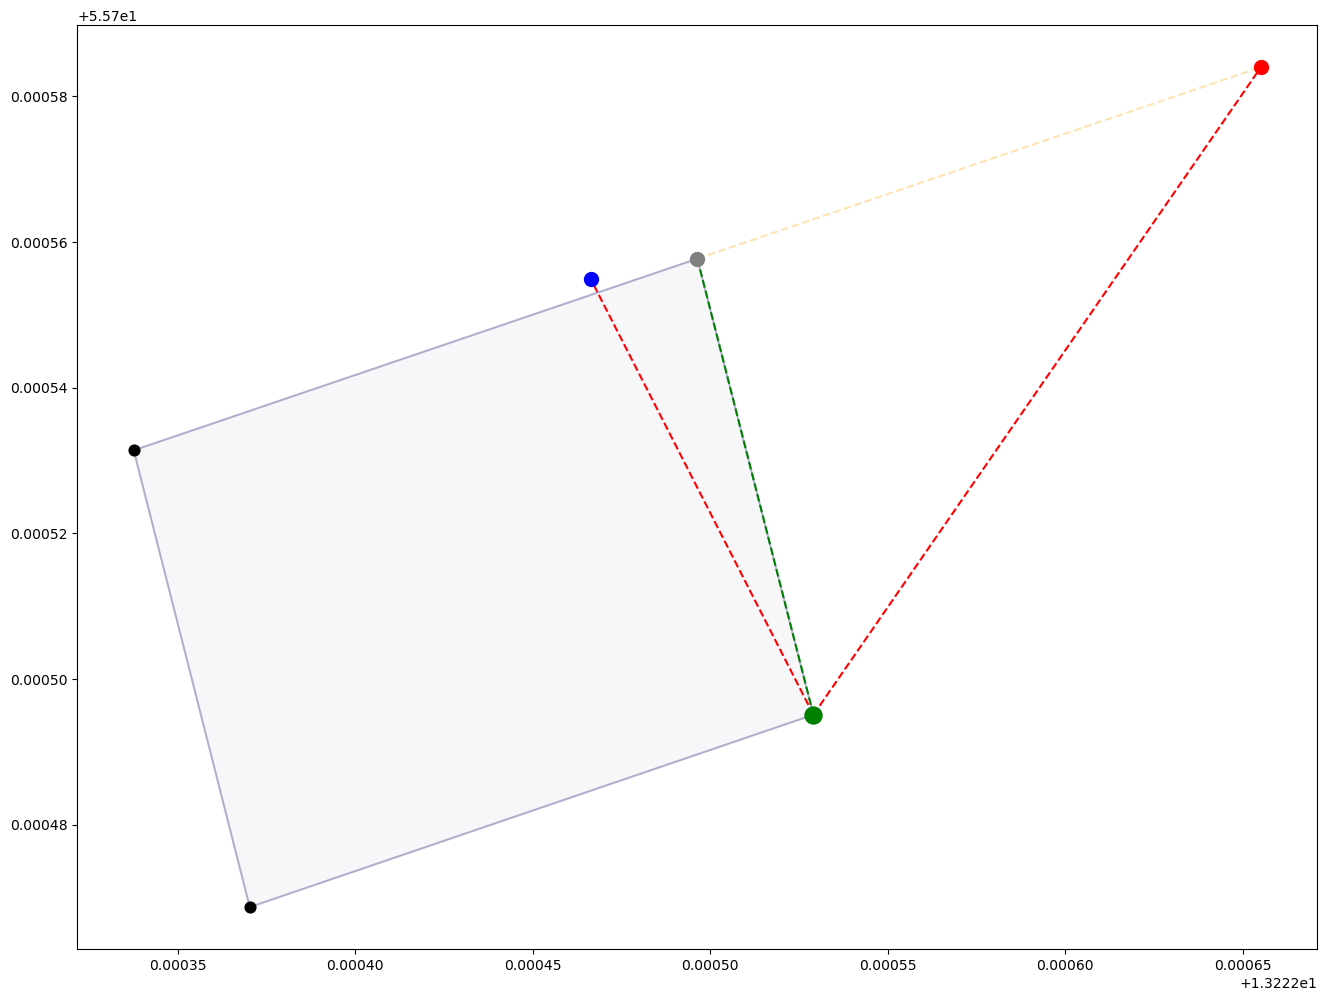

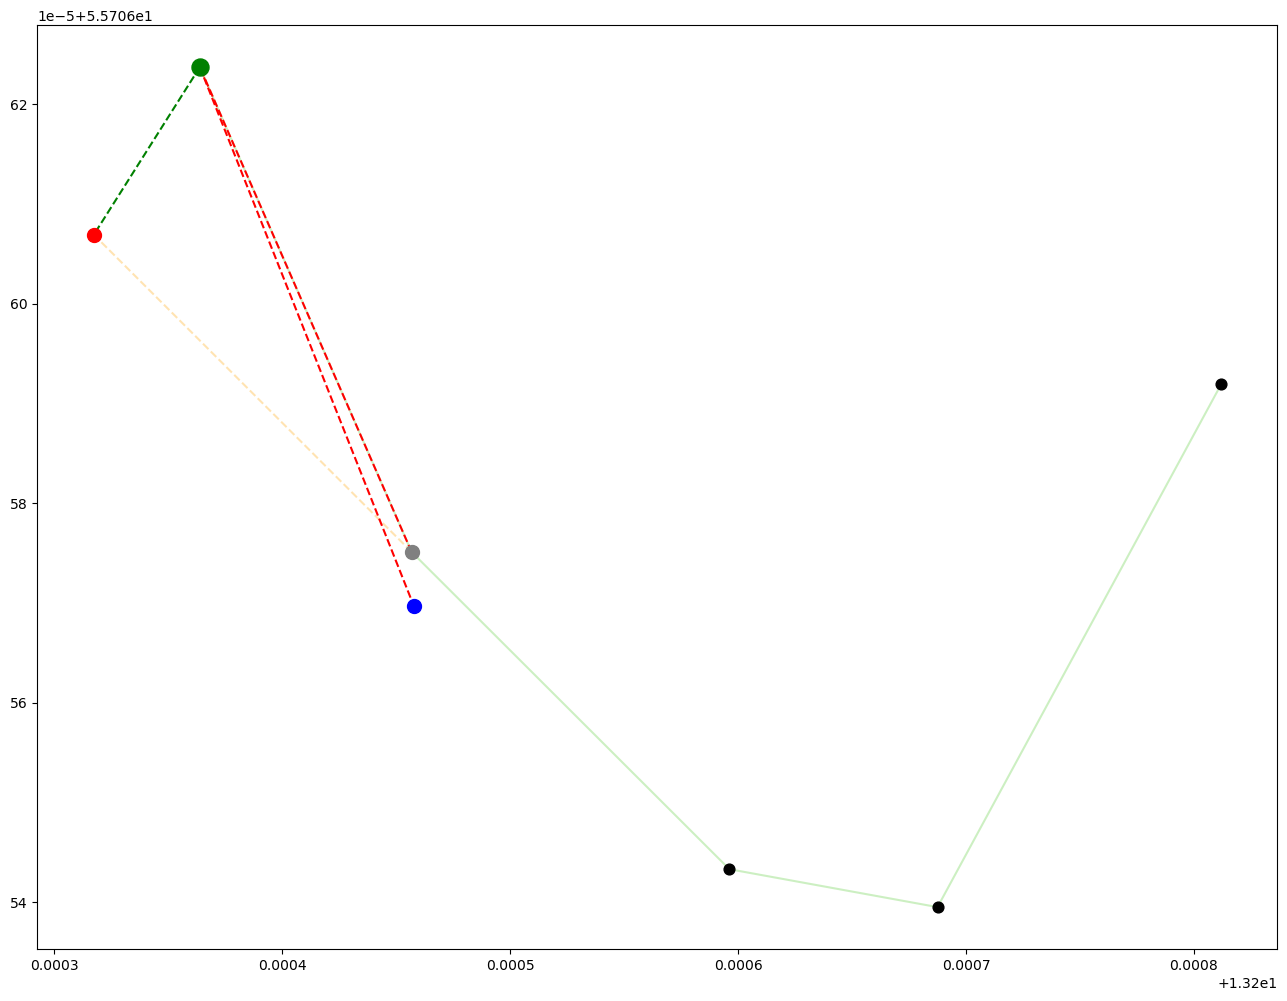

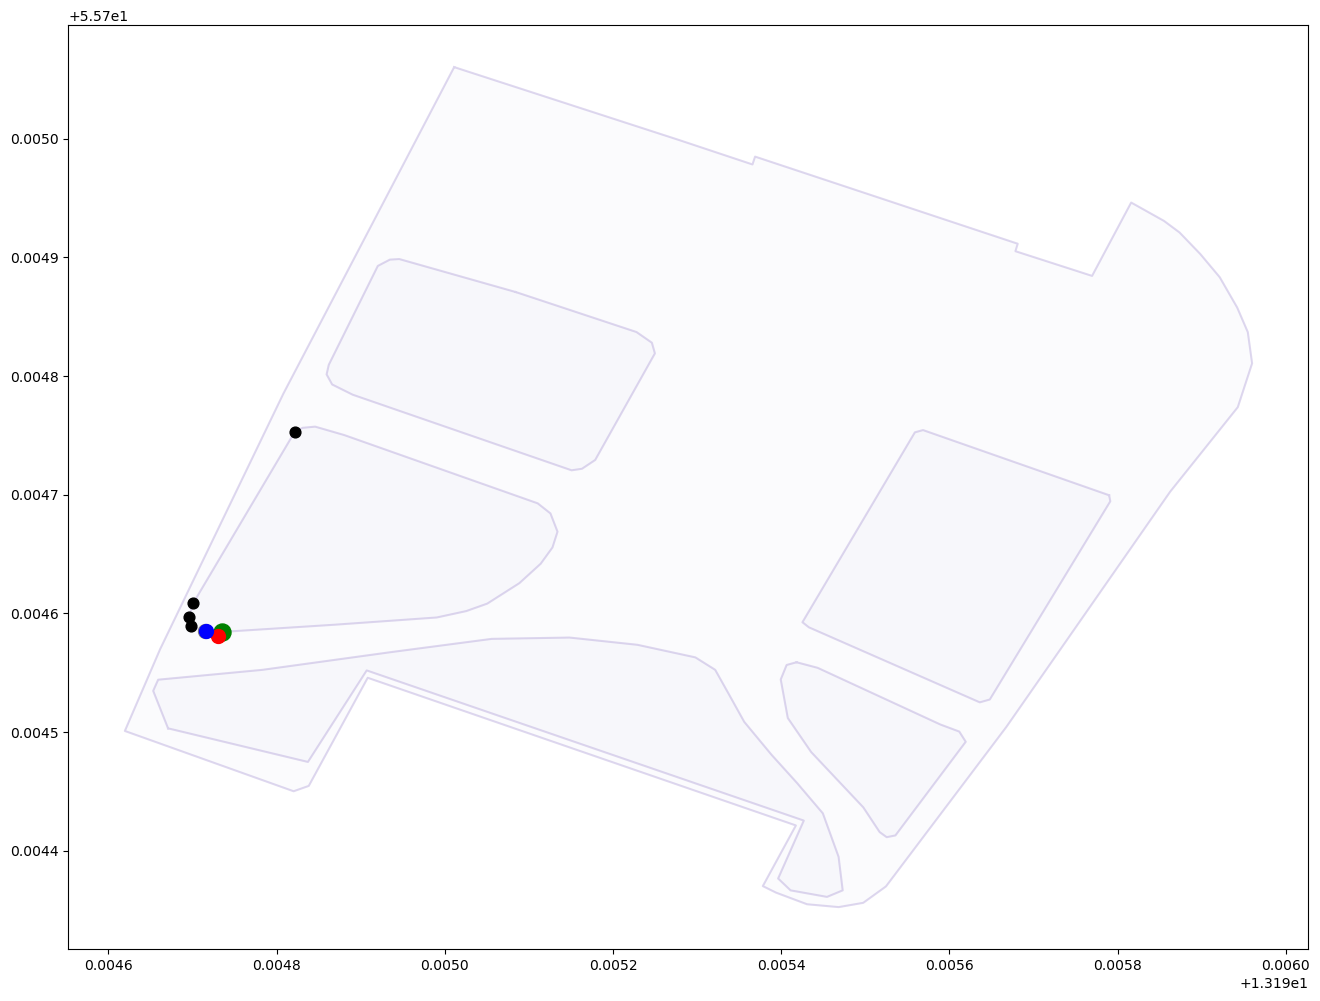

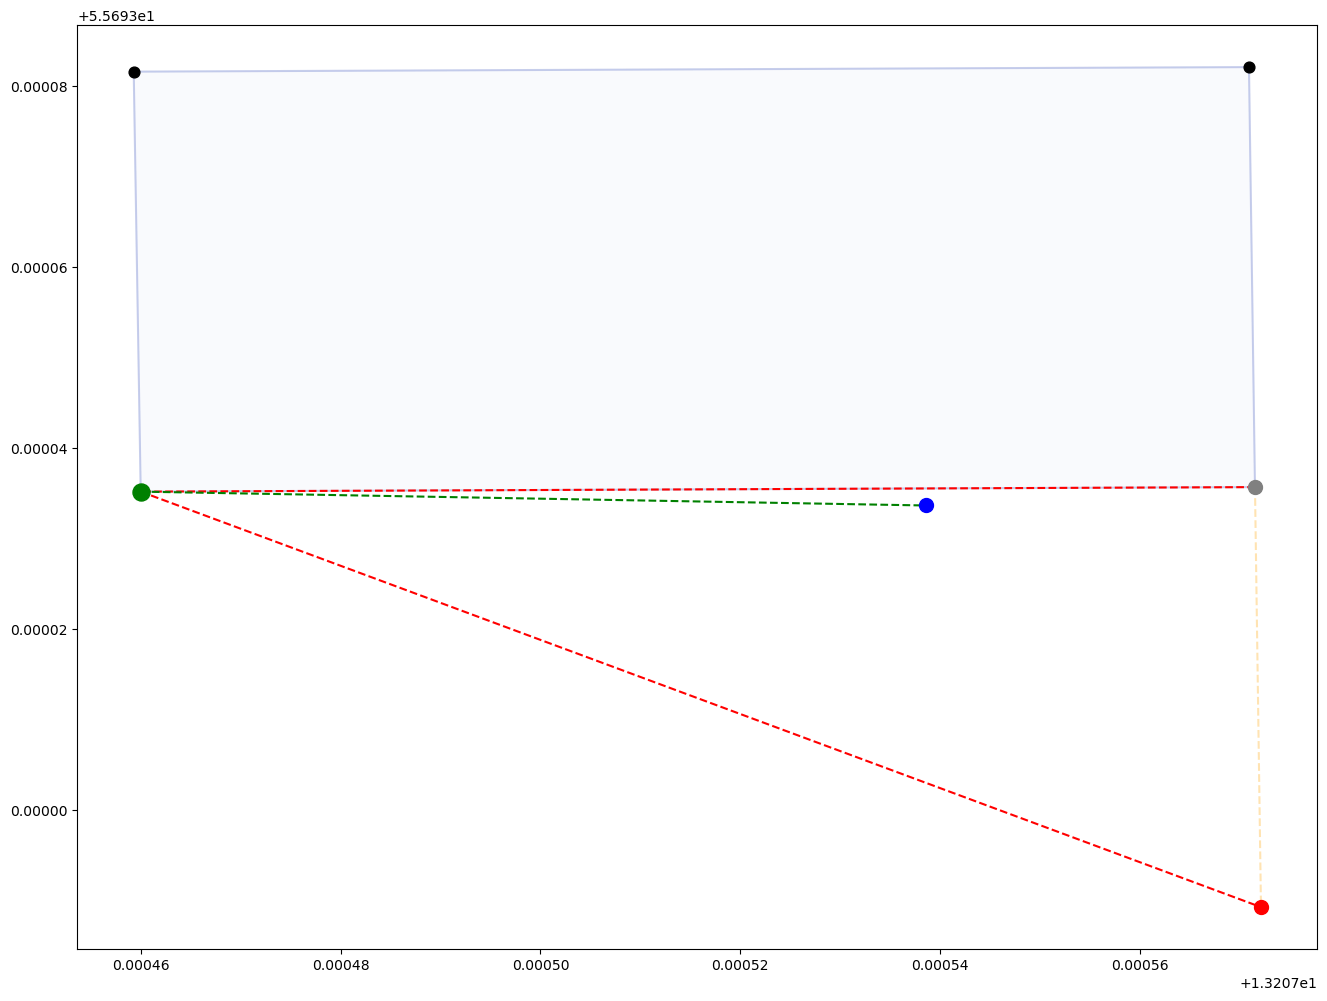

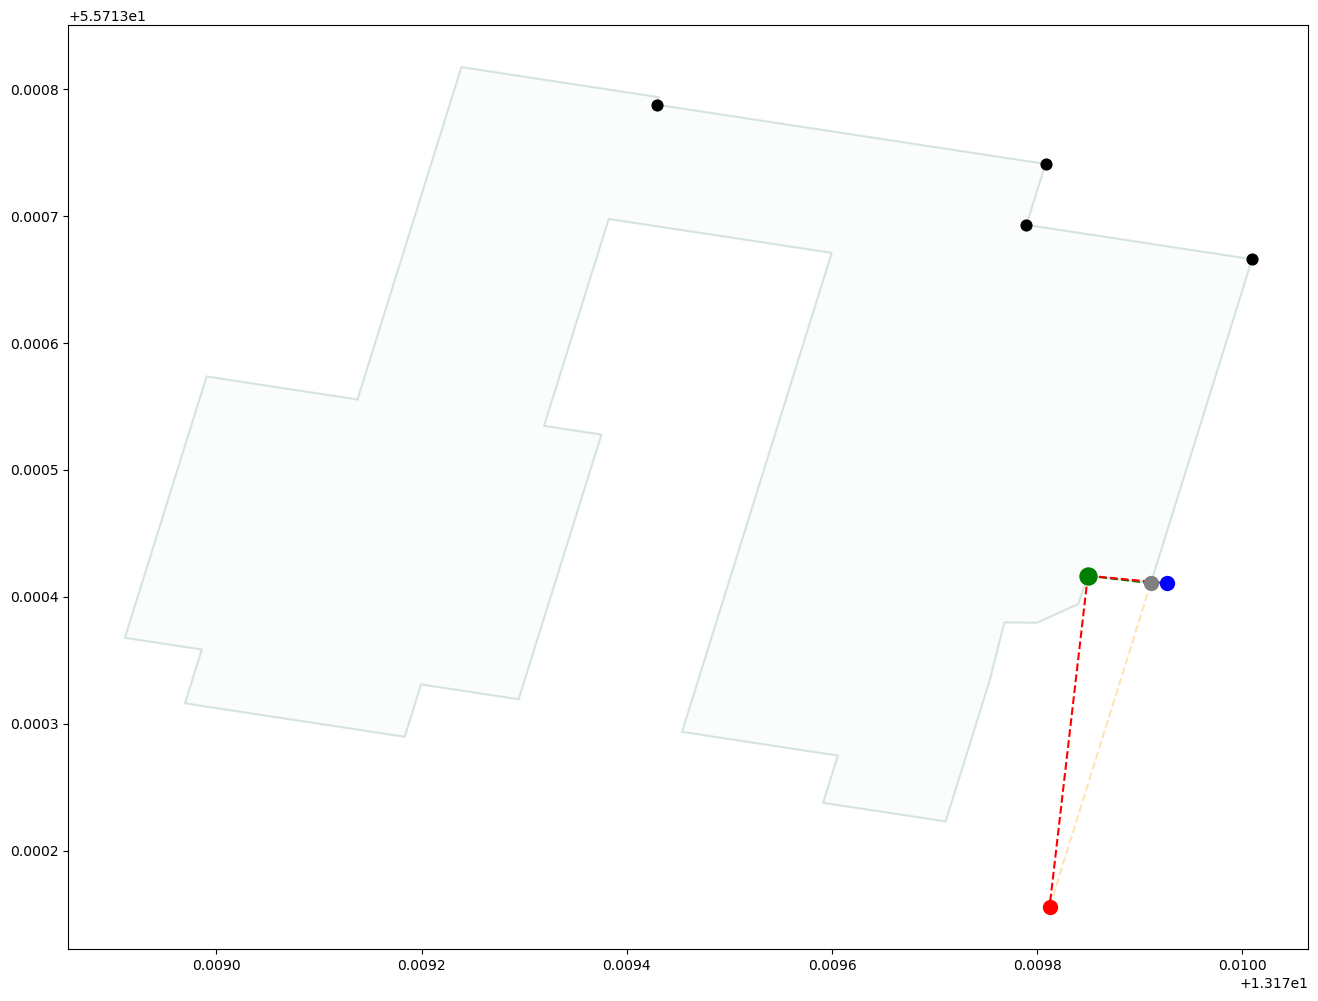

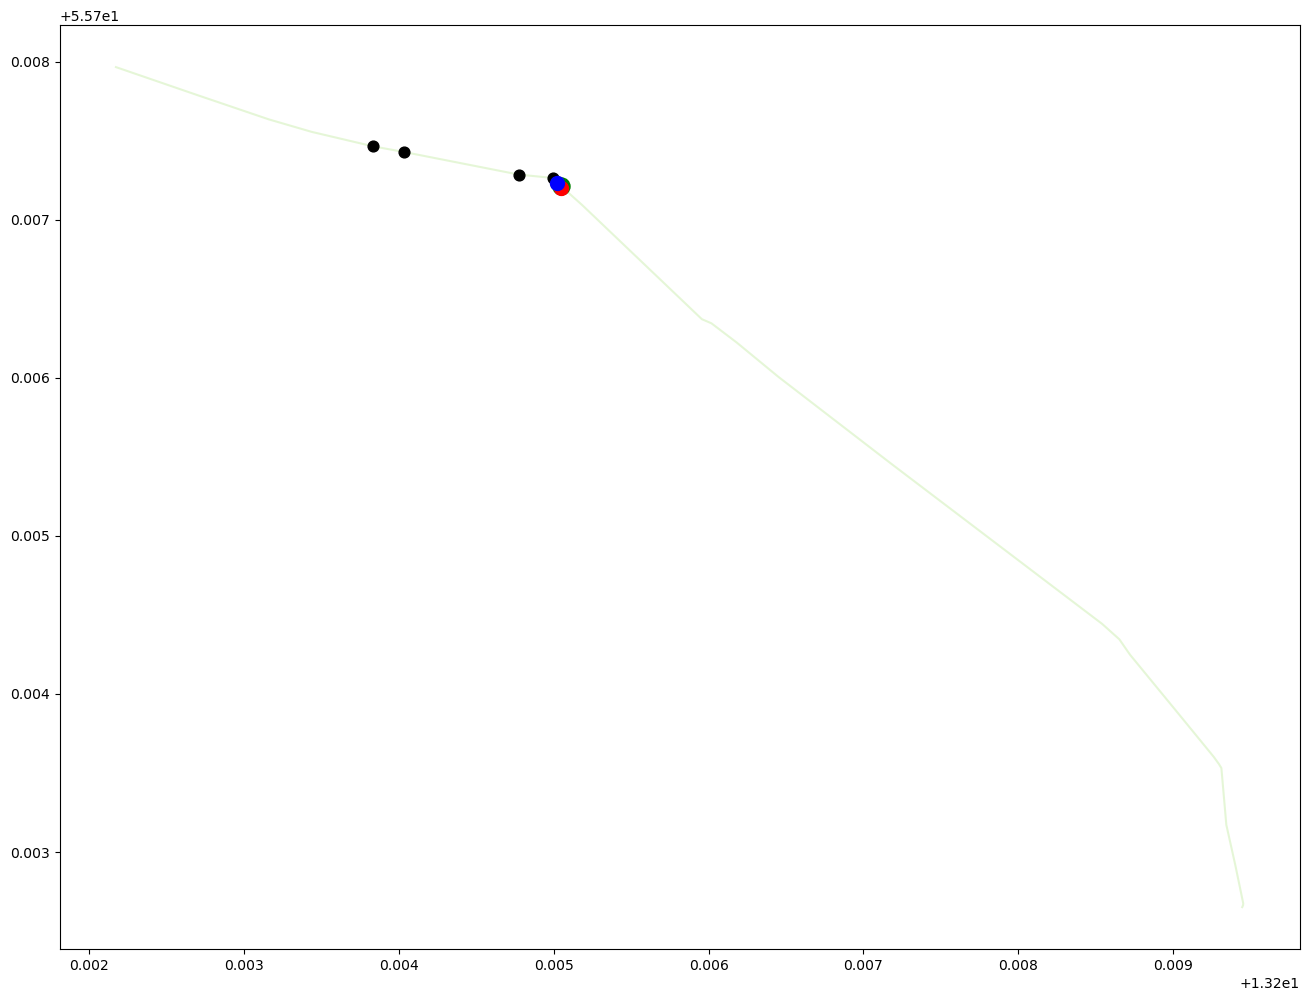

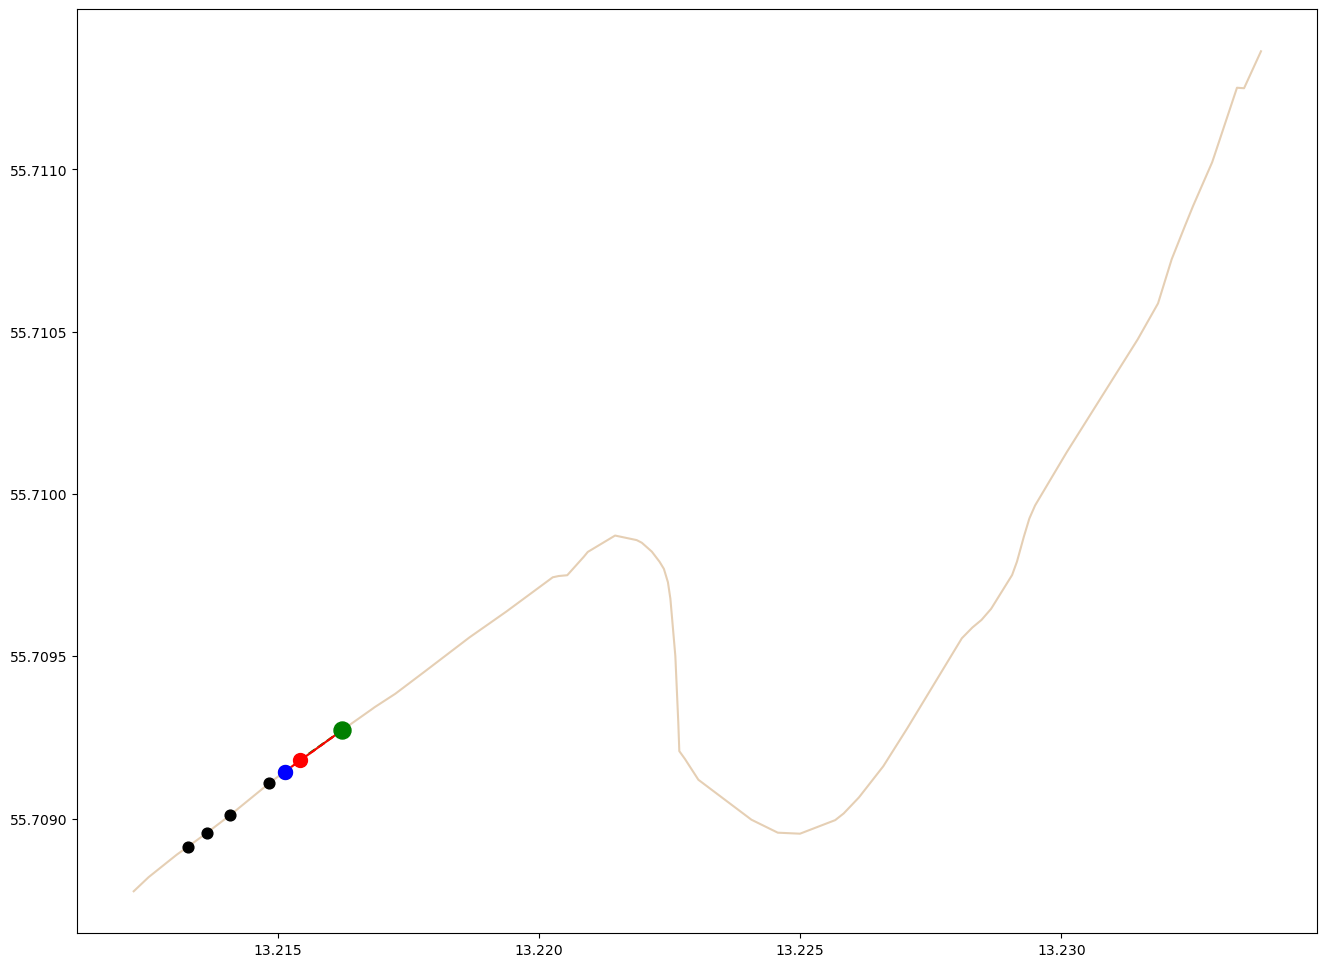

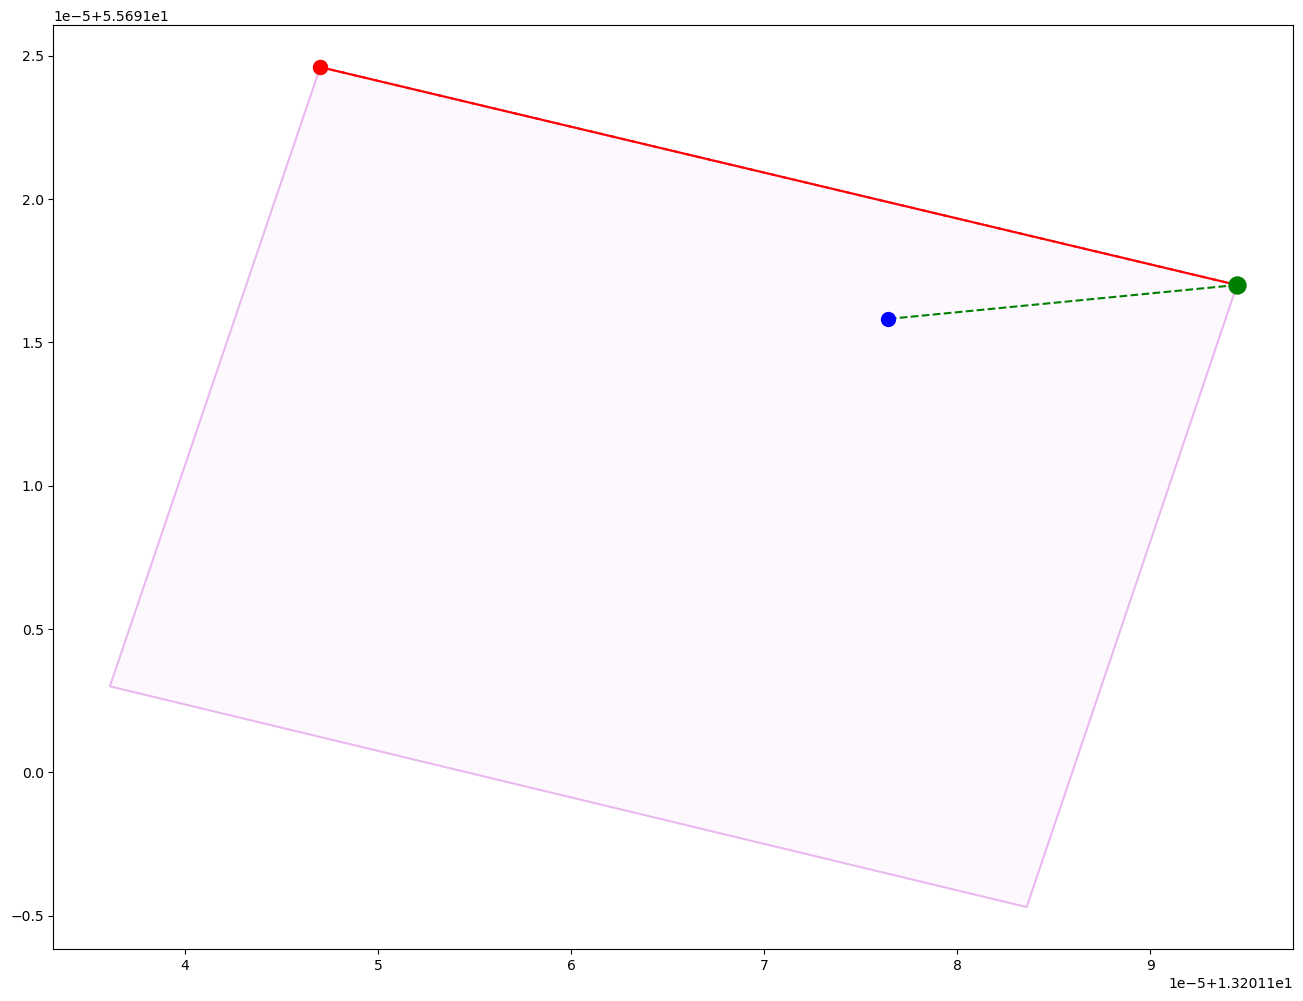

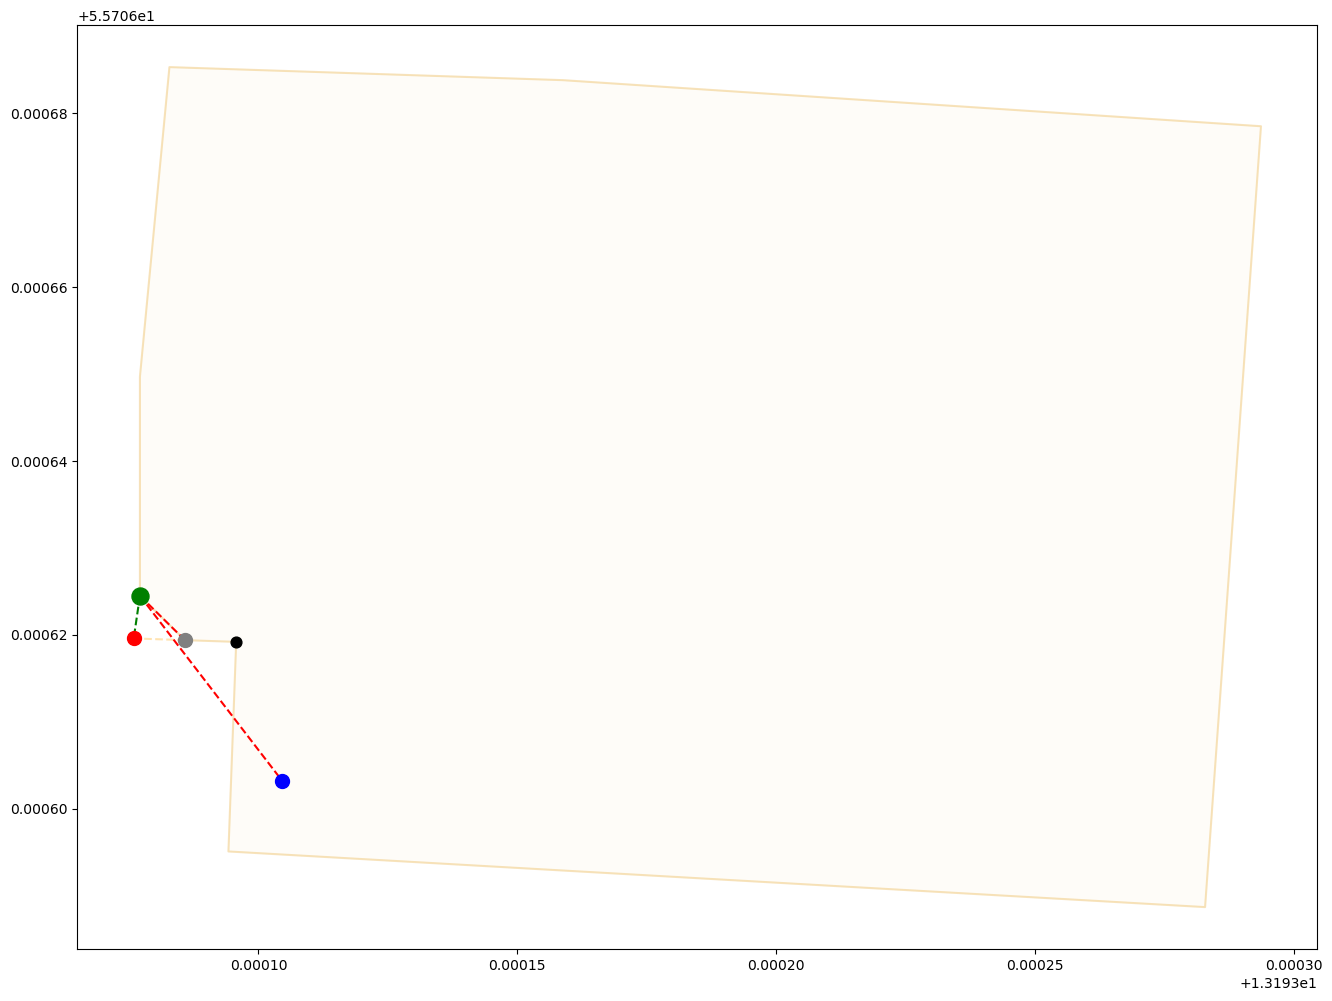

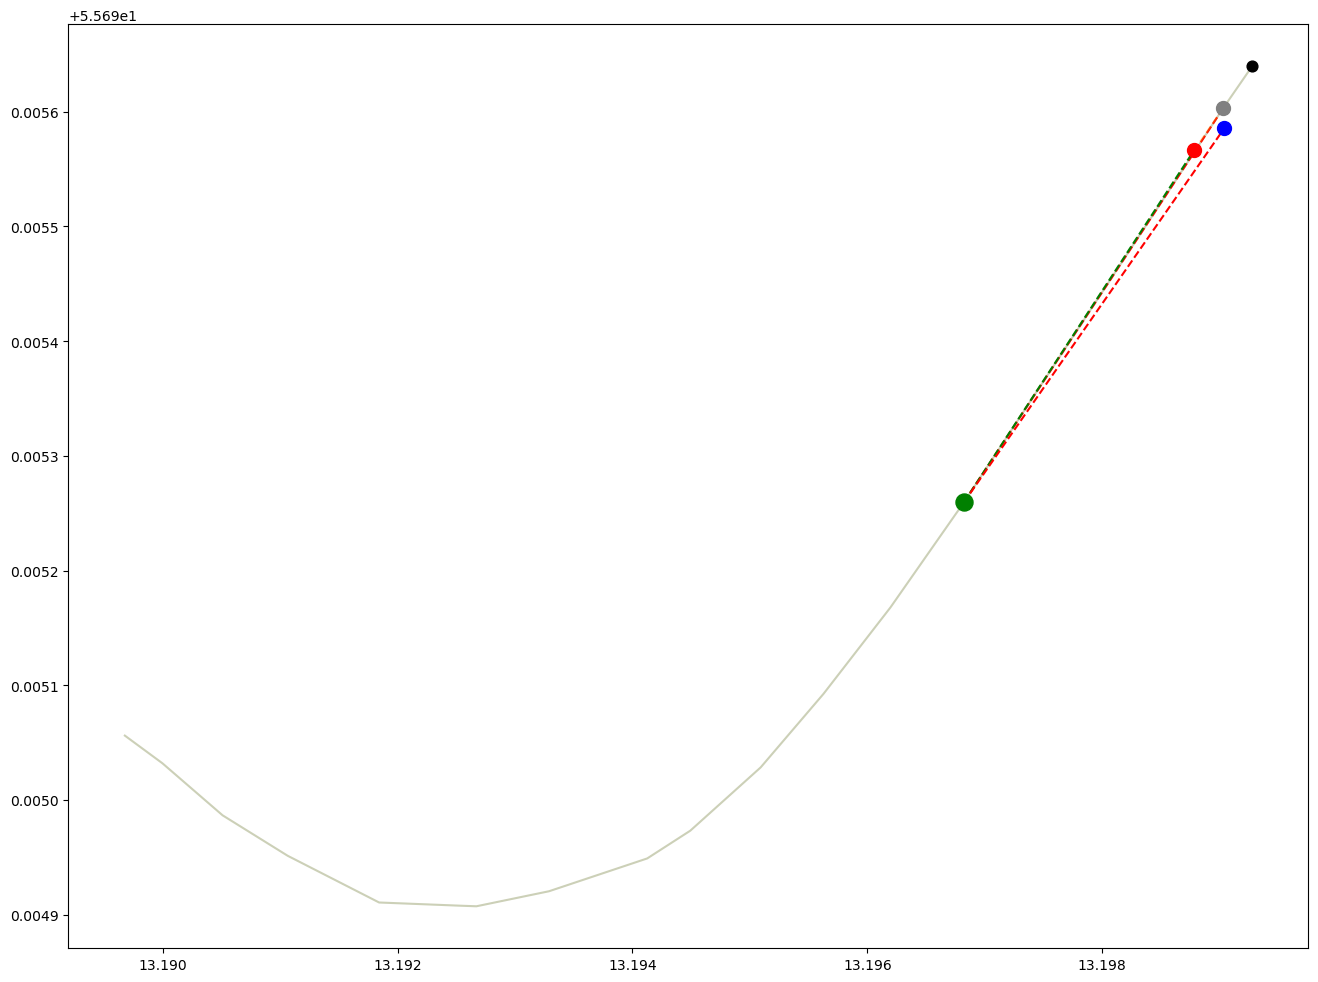

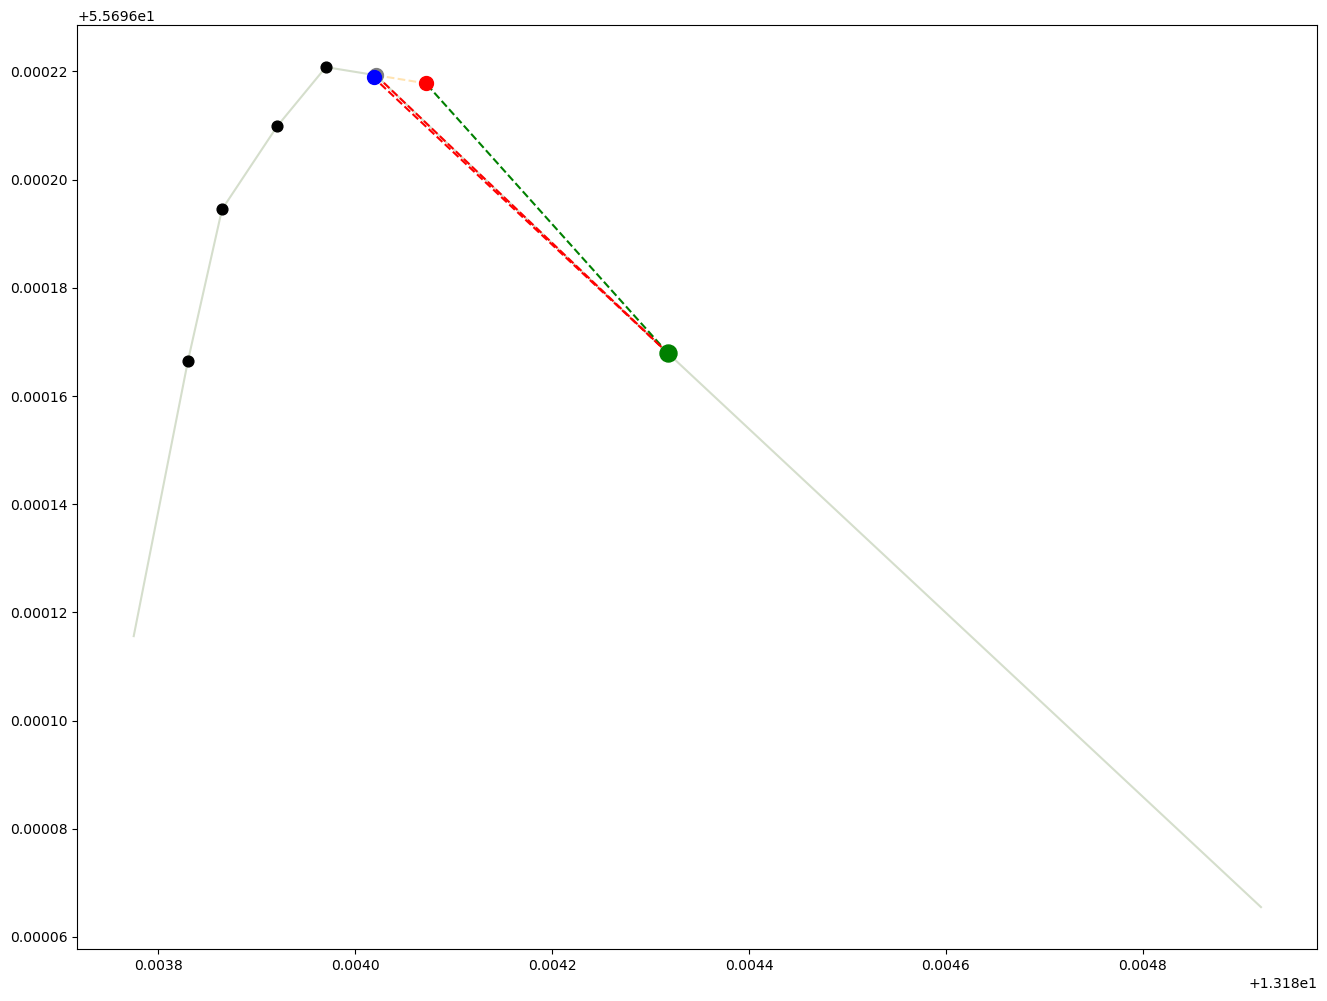

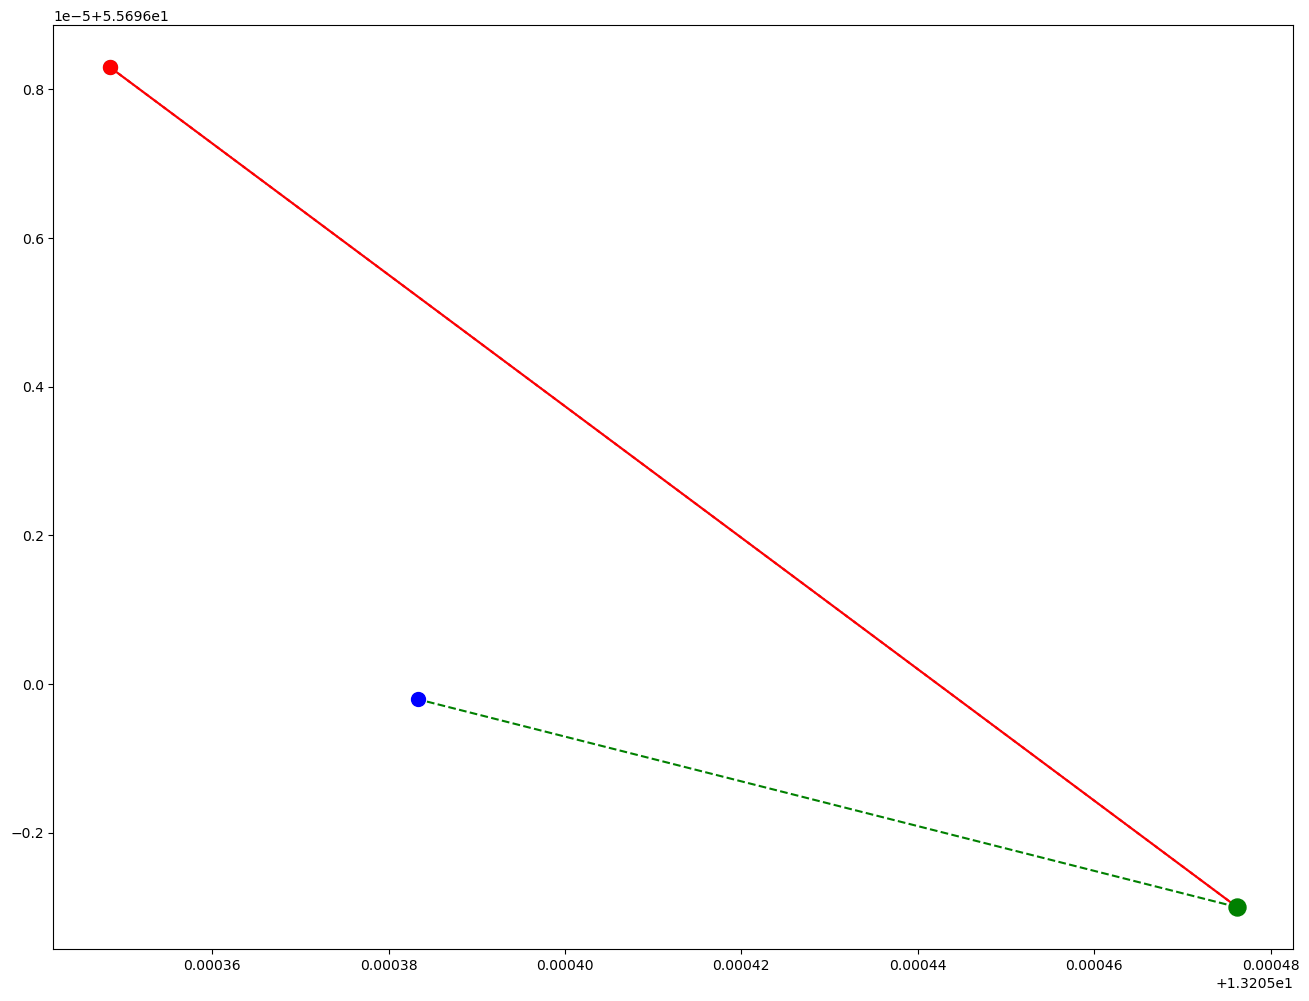

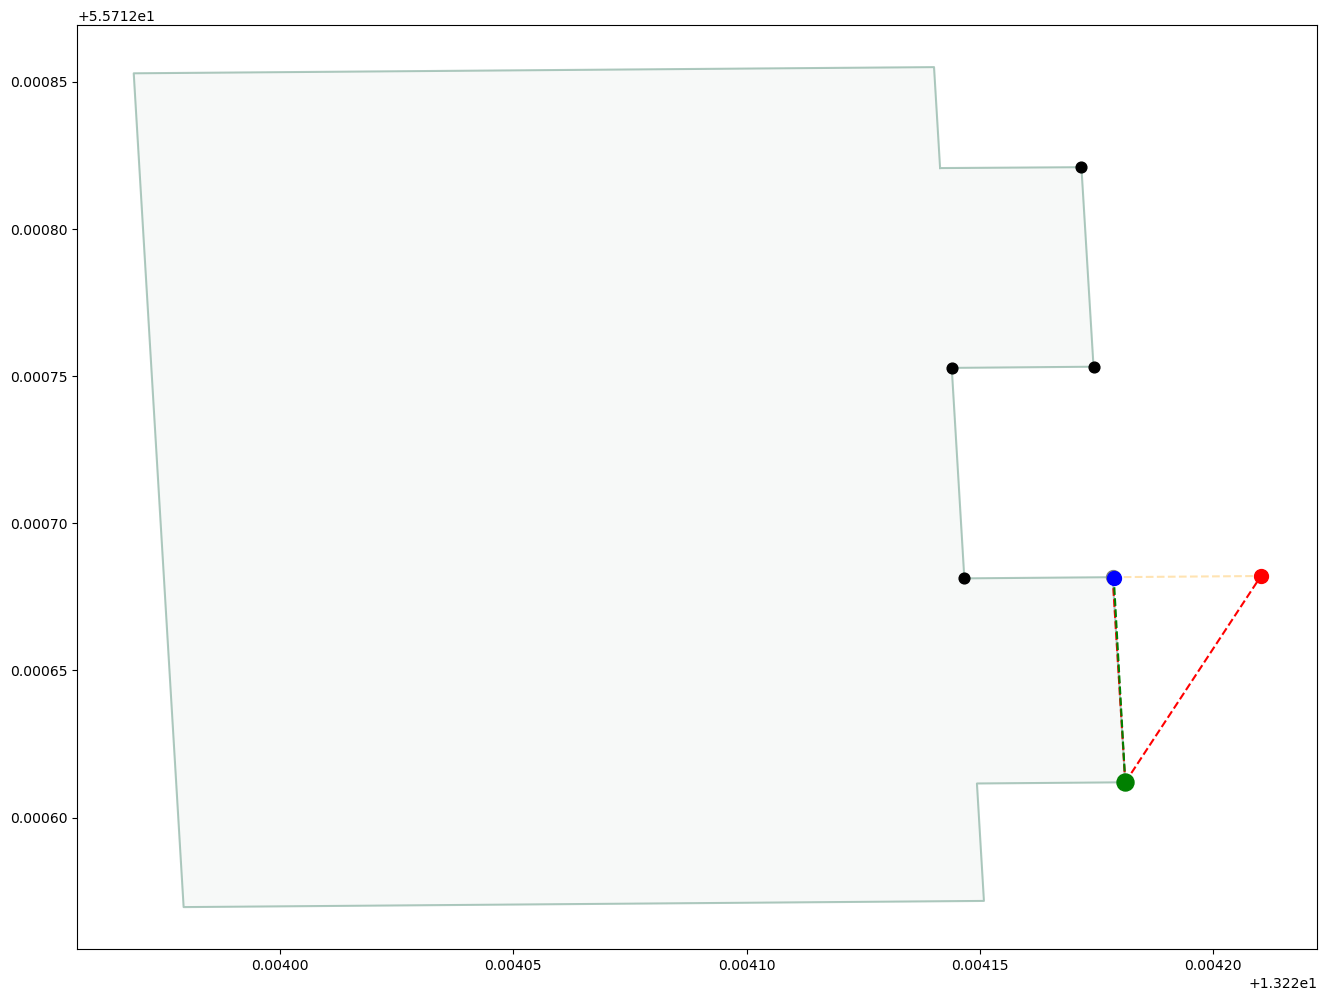

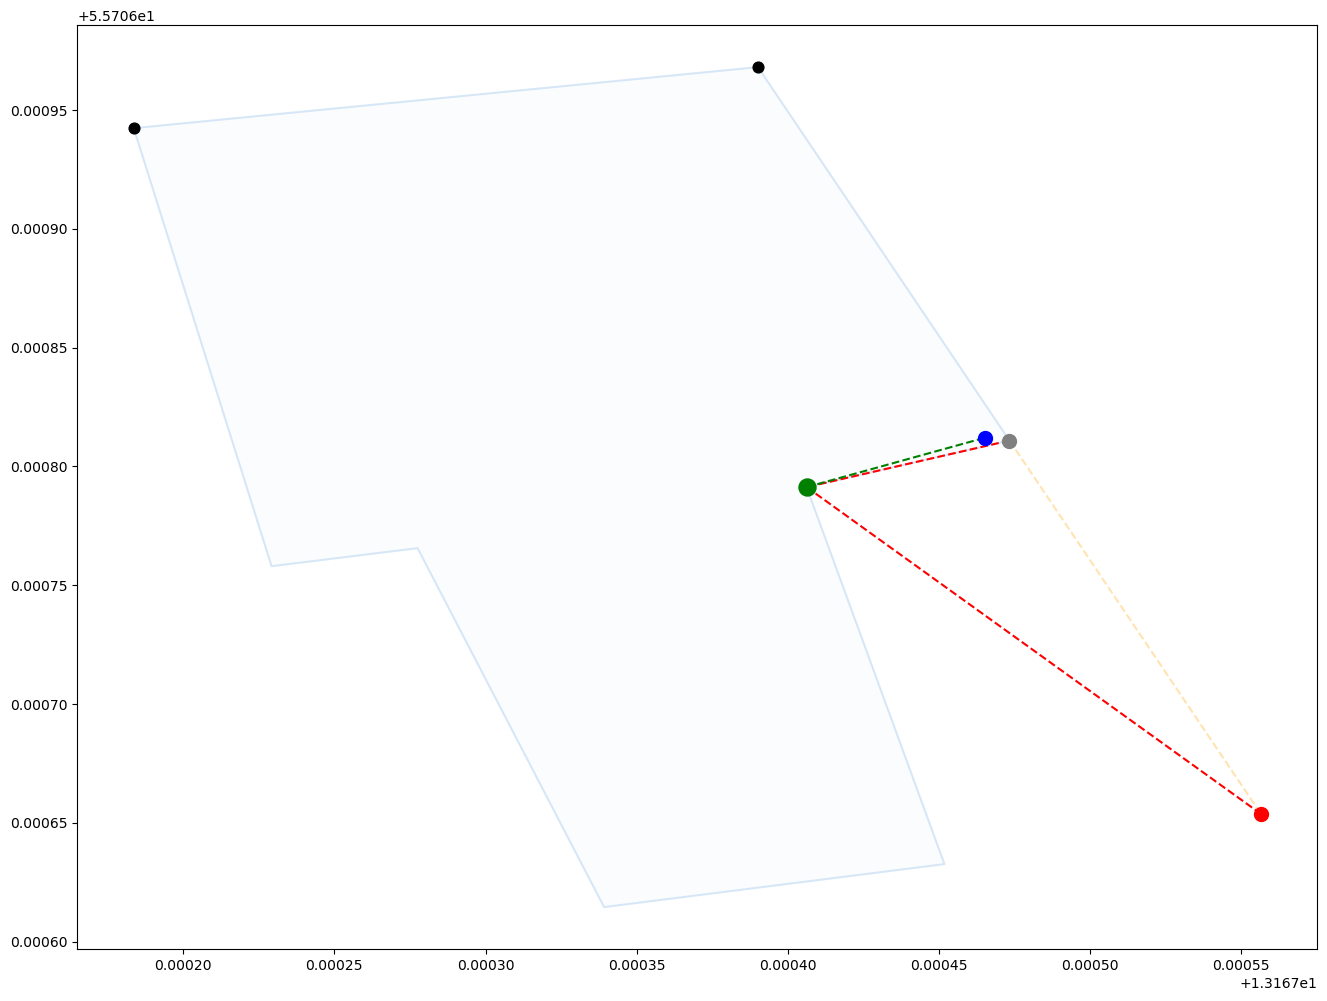

Model was better than None in: 6537 / 13123    ( 49.813305% )
Total MSE Model: 1.9734931743177673
Total MSE None: 1.9825053537551276
MSE Ratio (lower means model is better): 99.545415%

Linear Prediction was better than None in: 5314 / 13123    ( 40.493790% )
Total MSE Linear: 2.0717739595193114
Total MSE None: 1.9825053537551276
MSE Ratio (lower means linear is better): 104.502818%


In [146]:
from intersection.plotting import plot_geometry, create_canvas, plot_raw_points, plot_raw_point, plot_line

PRINT_VALIDATION = False
DRAW_MODEL_PREDICT = True

def flat_to_coord(x, idx=None):
    sep = len(x) // 2
    if idx != None:
        return np.array([x[idx], x[sep + idx]]) if USE_FLAT_LIST else x[idx]
    else:
        return np.array([[x[idx], x[sep + idx]] for idx in range(sep)]) if USE_FLAT_LIST else x

def linear_pred(x):
    if x[0][0] == 0:
        return 0
    elif x[1][0] == 0:
        return x[0]
    else:
        return x[0] + (x[0] - x[1])
    
def angle_pred(x):
    if x[0][0] == 0:
        return 0
    elif x[1][0] == 0:
        return x[0]
    
    # Get angle
    

def eval_set(geoms, X, y):
    y_hat = model.predict(X)
    pred_better_cnt = 0
    pred_tot_mse = 0
    none_tot_mse = 0
    lin_better_cnt = 0
    lin_tot_mse = 0
    # TODO: Use test set instead!
    for i in range(len(y_hat)):
        x_small = flat_to_coord(X[i])
        prev = x_small[0]
        
        distances = []
        distances.append(np.linalg.norm(y[i] - prev)) # Default
        distances.append(np.linalg.norm(y[i] - y_hat[i])) # Model

        predicted_is_better = distances[1] < distances[0]
        pred_better_cnt += 1 if predicted_is_better else 0
        pred_tot_mse += distances[1]
        none_tot_mse += distances[0]
        if PRINT_VALIDATION:
            print(prev)
            print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
            print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
            print('Better:', 'YES' if predicted_is_better else 'NO')
            print()

        ## Linear Prediction
        y_lin = linear_pred(x_small)
        distances.append(np.linalg.norm(y[i] - y_lin))
        lin_is_better = distances[2] < distances[0]
        lin_better_cnt += 1 if lin_is_better else 0
        lin_tot_mse += distances[2]

        if PRINT_VALIDATION:
            print('-- Linear Prediction')
            print(f'{i + 1}: Diff: {y[i] - y_lin}   predicted {y_lin}     distance {np.linalg.norm(y[i] - y_lin)}')
            print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
            print('Better:', 'YES' if lin_is_better else 'NO')
            print()

        if i % 1000 == 0:
            win_idx = np.argmin(distances)
            col_head = 'grey'
            col_tail = 'black'
            col_lin = 'orange'
            col_error = 'red'
            col_model = 'blue'
            col_correct = 'green'
            idx = geoms[i]
            create_canvas()

            # Draw shape + points used in model
            plot_geometry(shape(df.iloc[idx]), alpha=0.3)
            plot_raw_point(prev, color=col_head, size=100)
            plot_raw_point(y[i], color=col_correct, size=150)
            x_non_zero = list(filter(lambda x: not all(x == [0, 0]), x_small[1:]))
            plot_raw_points(x_non_zero, color=col_tail, size=60)
            plot_line(prev, y[i], solid=False, color=col_correct if win_idx == 0 else col_error)

            # Draw Linear Predict
            plot_raw_point(y_lin, color=col_error, size=100)
            plot_line(prev, y_lin, solid=False, color=col_lin, alpha=0.3)
            plot_line(y[i], y_lin, solid=False, color=col_correct if win_idx == 2 else col_error)

            if DRAW_MODEL_PREDICT:
                plot_raw_point(y_hat[i], color=col_model, size=100)
                plot_line(y[i], y_hat[i], solid=False, color=col_correct if win_idx == 1 else col_error)
            plt.show()

    print("Model was better than None in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')
    print("Total MSE Model:", pred_tot_mse)
    print("Total MSE None:", none_tot_mse)
    print("MSE Ratio (lower means model is better):", f'{(pred_tot_mse/none_tot_mse * 100):f}%')
    print()
    print("Linear Prediction was better than None in:", lin_better_cnt, '/', len(y_hat), '   (', f'{(lin_better_cnt/len(y_hat) * 100):f}%' , ')')
    print("Total MSE Linear:", lin_tot_mse)
    print("Total MSE None:", none_tot_mse)
    print("MSE Ratio (lower means linear is better):", f'{(lin_tot_mse/none_tot_mse * 100):f}%')

samples = len(X_validation)
eval_set(validation_geometries, X_validation[:samples], y_validation[:samples])